# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [30]:
# Load in the general demographics data.
azdias = pd.read_csv("Udacity_AZDIAS_Subset.csv", delimiter=";")

# Load in the feature summary file.
feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv", delimiter=";")

In [3]:
cat Data_Dictionary.md

# Data Dictionary for Identify Customer Segments Data

## Introduction

The data for this project consist of two files:

- Udacity_AZDIAS_Subset.csv: demographics data for the general population of
      Germany; 891211 persons (rows) x 85 features (columns)
- Udacity_CUSTOMERS_Subset.csv: demographics data for customers of a mail-order
      company; 191652 persons (rows) x 85 features (columns)

The columns in the general demographics file and customers data file are the
same. This file documents the features that appear in the data files, sorted in
order of appearance. Sections of this file is based on the level of measurement
of each feature. The file "AZDIAS_Feature_Summary.csv" contains a summary of
feature attributes, including information level, data type, and codes for
missing or unknown values.

### Table of Contents

 1. Person-level features
 2. Household-level features
 3. Building-level features
 4. RR4 micro-cell features
 5. RR3 micro-cell features
 6. Postcode-level fe

In [4]:
display(feat_info)

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


In [5]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print(azdias.shape)
display(azdias.head())
display(azdias.tail())

(891221, 85)


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
891216,-1,3,2,5.0,1,4,2,5,4,4,...,3.0,2.0,0.0,0.0,1.0,2.0,3.0,NaN,NaN,NaN
891217,-1,2,1,4.0,3,3,3,2,2,3,...,1.0,3.0,3.0,2.0,4.0,5.0,3.0,4.0,6.0,5.0
891218,-1,2,2,4.0,2,4,2,5,4,3,...,4.0,2.0,0.0,0.0,1.0,3.0,4.0,2.0,2.0,3.0
891219,-1,1,1,3.0,1,5,3,5,5,5,...,1.0,4.0,3.0,1.0,5.0,1.0,1.0,4.0,7.0,5.0
891220,-1,4,1,1.0,4,2,5,2,1,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,4.0,5.0


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [31]:
# Identify missing or unknown data values and convert them to NaNs.
def is_int(x):
    try:
        int(x)
        return True
    except ValueError:
        return False

def parse_missing_value_codes(s):
    '''
    @param string of missing value codes
    e.g. "[-1, 0]"
    '''
    s = s[1:-1].split(",") if s != "" else []
    s = [ int(x) if is_int(x) else x for x in s ]
    return s

missing_value_codes = feat_info["missing_or_unknown"].map(lambda x: parse_missing_value_codes(x))

In [32]:
def replace_missing_value_codes(df):
    df_output = df.copy()
    for i in range(len(df.columns)):
        if i % 5 == 0:
            print("Replacing missing value codes with np.nan for column {}/{}...".format(i, len(df_output.columns)-1))
        col_name = df_output.columns[i]
        df_output[col_name] = df_output[col_name].map(lambda x: np.nan if x in missing_value_codes[i] else x)
    return df_output

In [8]:
azdias_cleaned = replace_missing_value_codes(azdias)

Replacing missing value codes with np.nan for column 0/84...
Replacing missing value codes with np.nan for column 5/84...
Replacing missing value codes with np.nan for column 10/84...
Replacing missing value codes with np.nan for column 15/84...
Replacing missing value codes with np.nan for column 20/84...
Replacing missing value codes with np.nan for column 25/84...
Replacing missing value codes with np.nan for column 30/84...
Replacing missing value codes with np.nan for column 35/84...
Replacing missing value codes with np.nan for column 40/84...
Replacing missing value codes with np.nan for column 45/84...
Replacing missing value codes with np.nan for column 50/84...
Replacing missing value codes with np.nan for column 55/84...
Replacing missing value codes with np.nan for column 60/84...
Replacing missing value codes with np.nan for column 65/84...
Replacing missing value codes with np.nan for column 70/84...
Replacing missing value codes with np.nan for column 75/84...
Replacing 

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

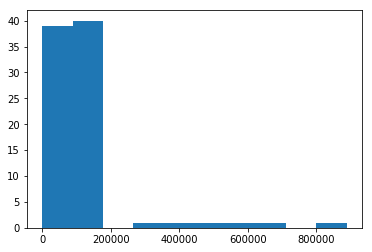

In [36]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
num_na_by_column = azdias_cleaned.isnull().sum(axis=0)

# Histogram
histogram = plt.hist(num_na_by_column)

In [37]:
# Summary statistics
num_na_by_column.describe()

count        85.000000
mean      98516.811765
std      146604.203317
min           0.000000
25%           0.000000
50%       93148.000000
75%      116515.000000
max      889061.000000
dtype: float64

In [38]:
# Compute the outlier threshold by 0.75 quantile + 1.5 * IQR
iqr = num_na_by_column.quantile(0.75) - num_na_by_column.quantile(0.25)
OUTLIER_THRESHOLD = num_na_by_column.quantile(0.75) + 1.5 * iqr

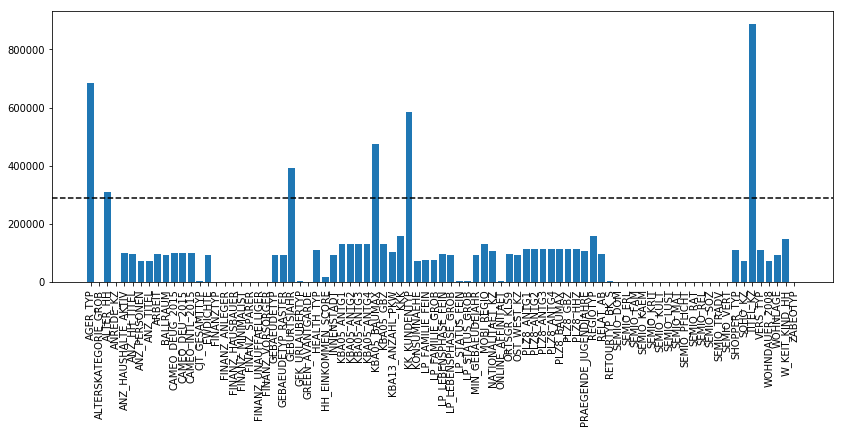

In [39]:
# Plot bar chart
fig = plt.figure(figsize=(14, 5))
plt.bar(x=num_na_by_column.index, height=num_na_by_column)
ticks = plt.xticks(rotation=90)
hlines = plt.axhline(OUTLIER_THRESHOLD, linestyle="--", color="black")

In [40]:
# Outliers:
outlier_columns = num_na_by_column.index[num_na_by_column > OUTLIER_THRESHOLD]

In [14]:
outlier_columns

Index(['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP',
       'KBA05_BAUMAX'],
      dtype='object')

In [15]:
# Investigate patterns in the amount of missing data in each column.
for val in num_na_by_column[num_na_by_column > 0].unique():
    na_count_grp = num_na_by_column[num_na_by_column==val].index.tolist()
    if len(na_count_grp) > 1:
        print("Variables with {} missing values: \n{}".format(val, na_count_grp))
        print("")

Variables with 4854 missing values: 
['CJT_GESAMTTYP', 'GFK_URLAUBERTYP', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'RETOURTYP_BK_S', 'ONLINE_AFFINITAET']

Variables with 111196 missing values: 
['HEALTH_TYP', 'SHOPPER_TYP', 'VERS_TYP']

Variables with 77792 missing values: 
['LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB']

Variables with 73499 missing values: 
['SOHO_KZ', 'ANZ_PERSONEN', 'ANZ_TITEL', 'WOHNDAUER_2008']

Variables with 93148 missing values: 
['GEBAEUDETYP', 'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'WOHNLAGE']

Variables with 99352 missing values: 
['CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CAMEO_INTL_2015']

Variables with 133324 missing values: 
['KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_GBZ', 'MOBI_REGIO']

Variables with 93740 missing values: 
['BALLRAUM', 'EWDICHTE', 'INNENSTADT']

Variables with 158064 missing values: 
['KKK', 'REGIOTYP']

Variables with 116515 missing values: 
['PLZ8_ANTG1', 'PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_BAUMAX', 'PLZ8_HHZ', 'PLZ8

* Variables with 4854 missing values: 
    * ['CJT_GESAMTTYP', 'GFK_URLAUBERTYP', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'RETOURTYP_BK_S', 'ONLINE_AFFINITAET']
    * ONLINE_AFFINITAET is a RR1 region-level feature (7) while all other features are personal-level (1).

* Variables with 111196 missing values: 
    * ['HEALTH_TYP', 'SHOPPER_TYP', 'VERS_TYP']
    * Personal typology features (1)

* Variables with 77792 missing values: 
    * ['LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB']
    * Family type features (1)

* Variables with 73499 missing values: 
    * ['SOHO_KZ', 'ANZ_PERSONEN', 'ANZ_TITEL', 'WOHNDAUER_2008']
    * Variables related to household, including length of residence or information on people in the residence. SOHO_KZ is personal-level (1) and the other three are household-level (2).

* Variables with 93148 missing values: 
    * ['GEBAEUDETYP', 'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'WOHNLAGE']
    * GEBAEUDETYP is a RR1 region level feature that documents ratio to commercial activity. The other three features are building-level features. 

* Variables with 99352 missing values: 
    * ['CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CAMEO_INTL_2015']
    * All RR4 micro-cell features (4)

* Variables with 133324 missing values: 
    * ['KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_GBZ', 'MOBI_REGIO']
    * KBA05 (5) variables count number of family houses, buildings, and types of buildings within RR3 microcells. MOBI_REGIO (7) documents movement patterns.

* Variables with 93740 missing values: 
    * ['BALLRAUM', 'EWDICHTE', 'INNENSTADT']
    * All postcode-level features (6)

* Variables with 158064 missing values: 
    * ['KKK', 'REGIOTYP']
    * Both RR1 region level features (7)

* Variables with 116515 missing values: 
    * ['PLZ8_ANTG1', 'PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_BAUMAX', 'PLZ8_HHZ', 'PLZ8_GBZ']
    * All PLZ8 macro-cell features (8)

* Variables with 97375 missing values: 
    * ['ARBEIT', 'RELAT_AB']
    * Both community-level features (9)

In [16]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
azdias_dropped_outliers = azdias_cleaned.drop(outlier_columns, axis=1)

In [17]:
def remove_outlier_columns(df):
    df_output = df.copy()
    
    # Determine outlier threshold
    num_na_by_column = df_output.isnull().sum(axis=0)
    iqr = num_na_by_column.quantile(0.75) - num_na_by_column.quantile(0.25)
    OUTLIER_THRESHOLD = num_na_by_column.quantile(0.75) + 1.5 * iqr
    
    # Find names of outlier columns and print
    outlier_columns = num_na_by_column.index[num_na_by_column > OUTLIER_THRESHOLD]
    print("Removing features with high number of missing values: {}".format(outlier_columns))
    
    # Drop outlier columns
    df_output.drop(outlier_columns, axis=1, inplace=True)
    return df_output

In [18]:
# Save data as checkpoint
azdias_cleaned.to_csv("azdias_cleaned.csv", index=False)
azdias_dropped_outliers.to_csv("azdias_dropped_outliers.csv", index=False)

In [35]:
# Read data back in
azdias_cleaned = pd.read_csv("azdias_cleaned.csv")
azdias_dropped_outliers = pd.read_csv("azdias_dropped_outliers.csv")

#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

* I grouped the columns by number of missing values, then used the documentation to examine each of these groups to see if there were any patterns. The details are documented in an above cell in this notebook.
* Most grouping patterns had the same degree of granularity between the features.  There are a few exceptions; for example, the first group consists of mostly personal-level features but includes a regional-level feature on online affinity. I can't think of an obvious reason for this pattern, but perhaps the regional-level online affinity feature was derived from personal online affinity, which would explain why the regional-level feature is missing at the same rate as other personal-level features. Overall, this is my best explanation for all patterns that occurred across multiple levels of granularity; if we examine the features in question, this explanation seems like it could be plausible.
* The columns that were removed from the dataset were `AGER_TYP`, `GEBURTSJAHR`, `TITEL_KZ`, `ALTER_HH`, `KK_KUNDENTYP`, and `KBA05_BAUMAX`.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [20]:
# How much data is missing in each row of the dataset?
row_null_totals = azdias_dropped_outliers.isnull().sum(axis=1)

In [21]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

# Define outlier threshold
iqr = row_null_totals.quantile(0.75) - row_null_totals.quantile(0.25)
MISSING_VAL_THRESHOLD = row_null_totals.quantile(0.75) + 1.5 * iqr

# Split dataset
above_threshold = azdias_dropped_outliers.isnull().sum(axis=1) > MISSING_VAL_THRESHOLD
azdias_above_threshold = azdias_dropped_outliers[above_threshold]
azdias_below_threshold = azdias_dropped_outliers[~above_threshold]

In [26]:
def remove_outlier_rows(df):
    row_null_totals = df.isnull().sum(axis=1)
    
    # Define outlier threshold
    iqr = row_null_totals.quantile(0.75) - row_null_totals.quantile(0.25)
    MISSING_VAL_THRESHOLD = row_null_totals.quantile(0.75) + 1.5 * iqr

    # Split dataset
    above_threshold = row_null_totals > MISSING_VAL_THRESHOLD
    return df[~above_threshold]

def get_outlier_rows(df):
    row_null_totals = df.isnull().sum(axis=1)
    
    # Define outlier threshold
    iqr = row_null_totals.quantile(0.75) - row_null_totals.quantile(0.25)
    MISSING_VAL_THRESHOLD = row_null_totals.quantile(0.75) + 1.5 * iqr

    # Split dataset
    above_threshold = row_null_totals > MISSING_VAL_THRESHOLD
    return df[above_threshold]

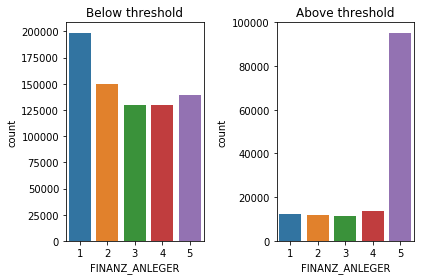

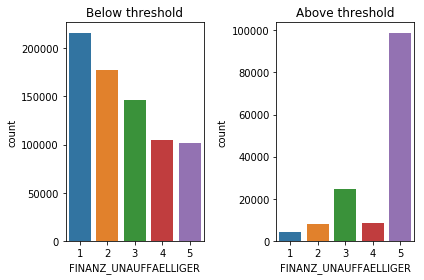

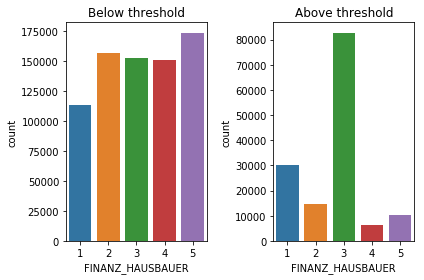

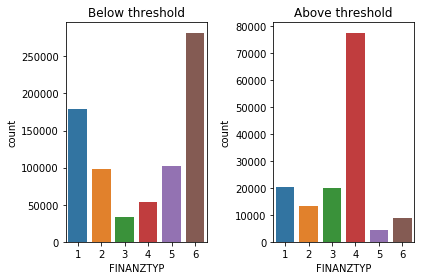

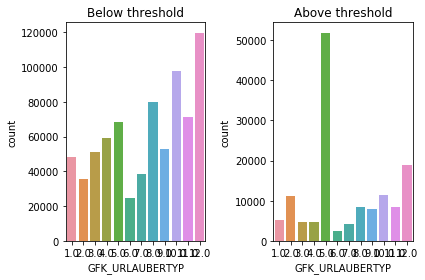

In [23]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
def compare_subsets(col_name):
    f, ax = plt.subplots(1, 2)
    sns.countplot(azdias_below_threshold.loc[:, col_name], ax=ax[0]).set_title("Below threshold")
    sns.countplot(azdias_above_threshold.loc[:, col_name], ax=ax[1]).set_title("Above threshold")
    f.tight_layout()
    
compare_subsets(azdias_above_threshold.columns[6])
compare_subsets(azdias_above_threshold.columns[7])
compare_subsets(azdias_above_threshold.columns[8])
compare_subsets(azdias_above_threshold.columns[9])
compare_subsets(azdias_above_threshold.columns[10])

#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

* Based on the examination of count plots, the data with lots of missing values (above threshold) have a different distribution of values for most features. In particular, for many features, the data above the missing value threshold seems to be disproportionately concentrated in one value of the feature. In contrast, the data below the missing value threshold exhibit a comparatively more even distribution across the values of each feature.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [24]:
# How many features are there of each data type?
feat_info["type"].value_counts()

ordinal        49
categorical    21
mixed           7
numeric         7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [25]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
cat_vars = feat_info.loc[feat_info["type"]=="categorical", "attribute"]
cat_vars = cat_vars[~cat_vars.isin(outlier_columns)].reset_index(drop=True)

In [26]:
azdias_below_threshold[cat_vars].head()

,ANREDE_KZ,CJT_GESAMTTYP,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,GEBAEUDETYP,OST_WEST_KZ,CAMEO_DEUG_2015,CAMEO_DEU_2015
1,2,5.0,1,10.0,0,5.0,3.0,2.0,1.0,1.0,3.0,1.0,2.0,5,8.0,W,8.0,8A
2,2,3.0,1,10.0,1,1.0,1.0,3.0,2.0,1.0,2.0,0.0,1.0,5,1.0,W,4.0,4C
3,2,2.0,6,1.0,0,NaN,NaN,9.0,4.0,1.0,1.0,0.0,1.0,3,1.0,W,2.0,2A
4,1,5.0,5,5.0,0,10.0,5.0,3.0,2.0,1.0,2.0,0.0,2.0,4,1.0,W,6.0,6B
5,2,2.0,2,1.0,0,1.0,1.0,4.0,2.0,1.0,0.0,0.0,2.0,4,1.0,W,8.0,8C


In [27]:
binary_vars = []
multilevel_vars = []

for variable in cat_vars:
    counts = azdias_below_threshold[variable].value_counts()
    if len(counts) == 2:
        var_type = "binary"
        binary_vars.append(variable)
    elif len(counts) >=3:
        var_type = "multi-level categorical"
        multilevel_vars.append(variable)
    else:
        var_type = "single value"
    print("{} : {}".format(variable, var_type))

ANREDE_KZ : binary
CJT_GESAMTTYP : multi-level categorical
FINANZTYP : multi-level categorical
GFK_URLAUBERTYP : multi-level categorical
GREEN_AVANTGARDE : binary
LP_FAMILIE_FEIN : multi-level categorical
LP_FAMILIE_GROB : multi-level categorical
LP_STATUS_FEIN : multi-level categorical
LP_STATUS_GROB : multi-level categorical
NATIONALITAET_KZ : multi-level categorical
SHOPPER_TYP : multi-level categorical
SOHO_KZ : binary
VERS_TYP : binary
ZABEOTYP : multi-level categorical
GEBAEUDETYP : multi-level categorical
OST_WEST_KZ : binary
CAMEO_DEUG_2015 : multi-level categorical
CAMEO_DEU_2015 : multi-level categorical


In [28]:
azdias_recoded = azdias_below_threshold.copy()

# Using a combination of the dataframe preview and the type printout, recode the multi-level categoricals -
# Re-encode categorical variable(s) to be kept in the analysis.
for var in multilevel_vars:
    print("Variable: {} recoded with one hot encoding".format(var))
    encoded_var = pd.get_dummies(azdias_recoded[var], prefix=var)
    azdias_recoded = pd.concat([azdias_recoded, encoded_var], axis=1)
    azdias_recoded.drop(var, axis=1, inplace=True)
    
# Recode the non-numeric binary variable
for var in binary_vars:
    if azdias_recoded[var].dtype=="object":
        unique_vals = azdias_recoded[var].unique()
        for i in range(len(unique_vals)):
            print("Variable: {}\t Value {} recoded to {}".format(var, unique_vals[i], i))
            azdias_recoded.loc[azdias_recoded[var] == unique_vals[i], var] = i
        azdias_recoded[var] = azdias_recoded[var].astype("float64")

Variable: CJT_GESAMTTYP recoded with one hot encoding
Variable: FINANZTYP recoded with one hot encoding
Variable: GFK_URLAUBERTYP recoded with one hot encoding
Variable: LP_FAMILIE_FEIN recoded with one hot encoding
Variable: LP_FAMILIE_GROB recoded with one hot encoding
Variable: LP_STATUS_FEIN recoded with one hot encoding
Variable: LP_STATUS_GROB recoded with one hot encoding
Variable: NATIONALITAET_KZ recoded with one hot encoding
Variable: SHOPPER_TYP recoded with one hot encoding
Variable: ZABEOTYP recoded with one hot encoding
Variable: GEBAEUDETYP recoded with one hot encoding
Variable: CAMEO_DEUG_2015 recoded with one hot encoding
Variable: CAMEO_DEU_2015 recoded with one hot encoding
Variable: OST_WEST_KZ	 Value W recoded to 0
Variable: OST_WEST_KZ	 Value O recoded to 1


In [29]:
def recode_categorical(df):
    
    cat_vars = feat_info.loc[feat_info["type"]=="categorical", "attribute"]
    cat_vars = cat_vars[~cat_vars.isin(outlier_columns)].reset_index(drop=True)

    binary_vars = []
    multilevel_vars = []

    for variable in cat_vars:
        counts = df[variable].value_counts()
        if len(counts) == 2:
            binary_vars.append(variable)
        elif len(counts) >=3:
            multilevel_vars.append(variable)

    for var in multilevel_vars:
        print("Variable: {} recoded with one hot encoding".format(var))
        encoded_var = pd.get_dummies(df[var], prefix=var)
        df = pd.concat([df, encoded_var], axis=1)
        df.drop(var, axis=1, inplace=True)

    for var in binary_vars:
        if df[var].dtype=="object":
            unique_vals = df.loc[~df[var].isnull(), var].unique()
            for i in range(len(unique_vals)):
                print("Variable: {}\t Value {} recoded to {}".format(var, unique_vals[i], i))
                df.loc[df[var] == unique_vals[i], var] = i
            df[var] = df[var].astype("float64")
    
    return df

#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

* For this step, I started by identifying the list of categorical variables from `feat_info`. Next, I identified the sublist of binary variables and the sublist of multi-level categorical variables. I replaced each multi-level categorical variable with one hot encoding using `pd.get_dummies()`. Finally, I replaced each non-numeric binary variable with 0s and 1s. This was done by iterating over the list of binary variables, checking the dtype of each variable, and replacing only when the dtype was non-numeric.
* I chose not to drop any variables at this point. My rationale was that it was fine to recode and keep all features for the time being. If necessary, they could be dropped later in the process during feature selection.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [30]:
mixed_vars = feat_info.loc[feat_info["type"]=="mixed", "attribute"]
mixed_vars = mixed_vars[~mixed_vars.isin(outlier_columns)].reset_index(drop=True)
print(mixed_vars)

0      LP_LEBENSPHASE_FEIN
1      LP_LEBENSPHASE_GROB
2    PRAEGENDE_JUGENDJAHRE
3                 WOHNLAGE
4          CAMEO_INTL_2015
5              PLZ8_BAUMAX
Name: attribute, dtype: object


* LP_LEBENSPHASE_FEIN and LP_LEBENSPHASE_GROB capture the same type of information, just at different scales - LP_LEBENSPHASE_FEIN is at a finer scale. I'll actually drop both because there are other variables that capture similar information in person-level features group.
* I'll drop some of the information from WOHNLAGE because it's unclear how I would code the how "good/bad" a rural neighborhood is, and I'm uncomfortable with just imputing the means. However, I can create a new urban/rural indicator variable.
* I'll drop PLZ8_BAUMAX because there are other variables that capture similar information in the PLZ8 macro-cell features group.

In [31]:
azdias_recoded.drop(["LP_LEBENSPHASE_FEIN", "LP_LEBENSPHASE_GROB", "PLZ8_BAUMAX"], axis=1, inplace=True)

In [32]:
def helper1(x):
    '''
    Helper 1 to recode "PRAEGENDE_JUGENDJAHRE" decade part
    '''
    if x in [1, 2]:
        return 0
    elif x in [3, 4]:
        return 1
    elif x in [5, 6, 7]:
        return 2
    elif x in [8, 9]:
        return 3
    elif x in [10, 11, 12, 13]:
        return 4
    elif x in [14, 15]:
        return 5
    else:
        return None
    
def helper2(x):
    '''
    Helper 2 to recode "PRAEGENDE_JUGENDJAHRE" mvmt part
    '''
    if x in [1, 3, 5, 8, 10, 12, 14]:
        return 0
    elif x in [2, 4, 6, 7, 9, 11, 13, 15]:
        return 1
    else:
        return None
    
def helper3(x):
    '''
    Helper 3 to create rural flag from "WOHNLAGE"
    '''
    if x in [1, 2, 3, 4, 5]:
        return 0
    elif x in [7, 8]:
        return 1
    else:
        return None

In [33]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
values = azdias_recoded["PRAEGENDE_JUGENDJAHRE"]

azdias_recoded["PRAEGENDE_JUGENDJAHRE_DECADE"] = values.map(lambda x: helper1(x))
azdias_recoded["PRAEGENDE_JUGENDJAHRE_MVMT"] = values.map(lambda x: helper2(x))

# Drop old variable 
azdias_recoded.drop("PRAEGENDE_JUGENDJAHRE", axis=1, inplace=True)

In [34]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
values = azdias_recoded["CAMEO_INTL_2015"]

# Use x > 0 as a way to detect NaN values
azdias_recoded["CAMEO_INTL_2015_WEALTH"] = values.map(lambda x: int(list(str(int(x)))[0]) if not np.isnan(float(x)) else x)
azdias_recoded["CAMEO_INTL_2015_LIFESTG"] = values.map(lambda x: int(list(str(int(x)))[1]) if not np.isnan(float(x)) else x)

# Drop old variable
azdias_recoded.drop("CAMEO_INTL_2015", axis=1, inplace=True)

In [35]:
# Create rural flag
values = azdias_recoded["WOHNLAGE"]
azdias_recoded["IS_RURAL"] = values.map(lambda x: helper3(x))

azdias_recoded.drop("WOHNLAGE", axis=1, inplace=True)

In [36]:
def handle_mixed_vars(df):
    # Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
    values = df["PRAEGENDE_JUGENDJAHRE"]

    df["PRAEGENDE_JUGENDJAHRE_DECADE"] = values.map(lambda x: helper1(x))
    df["PRAEGENDE_JUGENDJAHRE_MVMT"] = values.map(lambda x: helper2(x))

    # Drop old variable 
    df.drop("PRAEGENDE_JUGENDJAHRE", axis=1, inplace=True)
    
    # Investigate "CAMEO_INTL_2015" and engineer two new variables.
    values = df["CAMEO_INTL_2015"]

    # Use x > 0 as a way to detect NaN values
    df["CAMEO_INTL_2015_WEALTH"] = values.map(lambda x: int(list(str(int(x)))[0]) if not np.isnan(float(x)) else x)
    df["CAMEO_INTL_2015_LIFESTG"] = values.map(lambda x: int(list(str(int(x)))[1]) if not np.isnan(float(x)) else x)

    # Drop old variable
    df.drop("CAMEO_INTL_2015", axis=1, inplace=True)
    
    # Create rural flag
    values = df["WOHNLAGE"]
    df["IS_RURAL"] = values.map(lambda x: helper3(x))

    df.drop("WOHNLAGE", axis=1, inplace=True)
    df.drop(["LP_LEBENSPHASE_FEIN", "LP_LEBENSPHASE_GROB", "PLZ8_BAUMAX"], axis=1, inplace=True)
    
    return df

In [37]:
# Save as checkpoint
azdias_recoded.to_csv("azdias_recoded.csv", index=False)

#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

As noted above, aside from the two specified features, the rest of the mixed-value features were handled in the following way:
* LP_LEBENSPHASE_FEIN and LP_LEBENSPHASE_GROB capture the same type of information, just at different scales - LP_LEBENSPHASE_FEIN is at a finer scale. I'll actually drop both because there are other variables that capture similar information in person-level features group.
* I'll drop some of the information from WOHNLAGE because it's unclear how I would code the how "good/bad" a rural neighborhood is, and I'm uncomfortable with just imputing the means. However, I can create a new urban/rural indicator variable.
* I'll drop PLZ8_BAUMAX because there are other variables that capture similar information in the PLZ8 macro-cell features group.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [38]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

In [39]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

In [40]:
# Check original variables if handled properly
def check_df(df):
    for index, row in feat_info[["attribute", "type"]].iterrows():
        if row["attribute"] in outlier_columns:
            if row["attribute"] in df.columns:
                print("{}: (*) {} is an outlier column and should be removed from the dataset.".format(index, row["attribute"]))
            else:
                print("{}: {} removed from dataset for being an outlier.".format(index, row["attribute"]))
        elif row["type"] in ["numeric", "interval", "ordinal"]:
            if row["attribute"] not in df.columns:
                print("{}: (*) Warning: {} is missing from the dataset.".format(index, row["attribute"]))
            else:
                print("{}: {} retained for being numeric, interval, or ordinal.".format(index, row["attribute"]))
        elif row["type"]=="categorical":
            if row["attribute"] in binary_vars:
                if row["attribute"] not in df.columns:
                    print("{}: (*) Warning: {} is missing from the dataset.".format(index, row["attribute"]))
                elif df[row["attribute"]].dtype=="object":
                    print("{}: (*) Warning: {} is not numerically encoded.".format(index, row["attribute"]))
                else:
                    print("{}: {} is a properly encoded binary feature.".format(index, row["attribute"]))
            else:
                if row["attribute"] not in df.columns:
                    print("{}: {} multi-level categorical variable handled properly.".format(index, row["attribute"]))
                else:
                    print("{}: (*) Warning: Check if {} multi-level categorical variable handled properly.".format(index, row["attribute"]))
        elif row["type"]=="mixed":
            if row["attribute"] not in df.columns:
                print("{}: {} mixed-feature handled properly, either removed or recoded.".format(index, row["attribute"]))
            else:
                print("{}: (*) Warning: mixed feature {} still in dataset, check if handled properly.".format(index, row["attribute"]))
    for col in df.columns[~df.columns.isin(feat_info["attribute"])]:
        if not any(a in col for a in multilevel_vars):
            print("Check if derived from mixed variable:", col)
    return

In [41]:
check_df(azdias_recoded)

0: AGER_TYP removed from dataset for being an outlier.
1: ALTERSKATEGORIE_GROB retained for being numeric, interval, or ordinal.
2: ANREDE_KZ is a properly encoded binary feature.
3: CJT_GESAMTTYP multi-level categorical variable handled properly.
4: FINANZ_MINIMALIST retained for being numeric, interval, or ordinal.
5: FINANZ_SPARER retained for being numeric, interval, or ordinal.
6: FINANZ_VORSORGER retained for being numeric, interval, or ordinal.
7: FINANZ_ANLEGER retained for being numeric, interval, or ordinal.
8: FINANZ_UNAUFFAELLIGER retained for being numeric, interval, or ordinal.
9: FINANZ_HAUSBAUER retained for being numeric, interval, or ordinal.
10: FINANZTYP multi-level categorical variable handled properly.
11: GEBURTSJAHR removed from dataset for being an outlier.
12: GFK_URLAUBERTYP multi-level categorical variable handled properly.
13: GREEN_AVANTGARDE is a properly encoded binary feature.
14: HEALTH_TYP retained for being numeric, interval, or ordinal.
15: LP_LEBEN

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [42]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    df_cleaned = replace_missing_value_codes(df)
    
    # remove selected columns and rows, ...
    
    # Originally here I tried to use a generic drop outlier function, but we want to drop the same columns
    df_dropped_outliers = df_cleaned.drop(outlier_columns, axis=1)
    df_below_threshold = remove_outlier_rows(df_dropped_outliers)
    
    # select, re-encode, and engineer column values.
    df = recode_categorical(df_below_threshold)
    df = handle_mixed_vars(df)
    
    # check dataframe
    check_df(df)

    # Return the cleaned dataframe.
    return df

In [43]:
customer_df = pd.read_csv("Udacity_CUSTOMERS_Subset.csv", delimiter=";")

In [44]:
cleaned_customer_df = clean_data(customer_df)

Replacing missing value codes with np.nan for column 0/84...
Replacing missing value codes with np.nan for column 5/84...
Replacing missing value codes with np.nan for column 10/84...
Replacing missing value codes with np.nan for column 15/84...
Replacing missing value codes with np.nan for column 20/84...
Replacing missing value codes with np.nan for column 25/84...
Replacing missing value codes with np.nan for column 30/84...
Replacing missing value codes with np.nan for column 35/84...
Replacing missing value codes with np.nan for column 40/84...
Replacing missing value codes with np.nan for column 45/84...
Replacing missing value codes with np.nan for column 50/84...
Replacing missing value codes with np.nan for column 55/84...
Replacing missing value codes with np.nan for column 60/84...
Replacing missing value codes with np.nan for column 65/84...
Replacing missing value codes with np.nan for column 70/84...
Replacing missing value codes with np.nan for column 75/84...
Replacing 

In [45]:
# Check that columns present in each dataframe are the same
compare_cols = pd.concat([pd.DataFrame(azdias_recoded.columns, columns=["azdias_cols"]), 
           pd.DataFrame(cleaned_customer_df.columns, columns=["customer_cols"])], axis=1)
compare_cols[compare_cols["azdias_cols"] != compare_cols["customer_cols"]].head()

,azdias_cols,customer_cols
132,GEBAEUDETYP_5.0,GEBAEUDETYP_6.0
133,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0
134,GEBAEUDETYP_8.0,CAMEO_DEUG_2015_1
135,CAMEO_DEUG_2015_1.0,CAMEO_DEUG_2015_2
136,CAMEO_DEUG_2015_2.0,CAMEO_DEUG_2015_3


In [46]:
# Add GEBAEUDETYP_5.0 column (with all zeroes) to cleaned_customer_df
cleaned_customer_df_2 = pd.concat([cleaned_customer_df.iloc[:, 0:132], 
           pd.DataFrame(np.zeros([len(cleaned_customer_df.index), 1]).astype(np.uint8), 
                                                 columns=["GEBAEUDETYP_5.0"]),
          cleaned_customer_df.iloc[:, 132:len(cleaned_customer_df.columns)]], axis=1)

In [47]:
compare_cols = pd.concat([pd.DataFrame(azdias_recoded.columns, columns=["azdias_cols"]), 
           pd.DataFrame(cleaned_customer_df_2.columns, columns=["customer_cols"])], axis=1)
compare_cols[compare_cols["azdias_cols"] != compare_cols["customer_cols"]]

,azdias_cols,customer_cols
135,CAMEO_DEUG_2015_1.0,CAMEO_DEUG_2015_1
136,CAMEO_DEUG_2015_2.0,CAMEO_DEUG_2015_2
137,CAMEO_DEUG_2015_3.0,CAMEO_DEUG_2015_3
138,CAMEO_DEUG_2015_4.0,CAMEO_DEUG_2015_4
139,CAMEO_DEUG_2015_5.0,CAMEO_DEUG_2015_5
140,CAMEO_DEUG_2015_6.0,CAMEO_DEUG_2015_6
141,CAMEO_DEUG_2015_7.0,CAMEO_DEUG_2015_7
142,CAMEO_DEUG_2015_8.0,CAMEO_DEUG_2015_8
143,CAMEO_DEUG_2015_9.0,CAMEO_DEUG_2015_9


In [48]:
# Ensure column names are the same
cleaned_customer_df_2.columns = azdias_recoded.columns

In [49]:
# Check that dtypes of all columns are the same
azdias_recoded.dtypes[azdias_recoded.dtypes != cleaned_customer_df_2.dtypes]

Series([], dtype: object)

In [50]:
# Save final cleaned versions for now
azdias_recoded.to_csv("azdias_FINAL_CLEAN.csv", index=False)
cleaned_customer_df_2.to_csv("cust_FINAL_CLEAN.csv", index=False)

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [2]:
# Read in clean azdias data
azdias_df = pd.read_csv("azdias_FINAL_CLEAN.csv")

In [3]:
# Maximum % of missing values in any column
np.mean(azdias_df.isnull(), axis=0).max()

0.060784972473896047

In [4]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
imp = Imputer()
azdias_imputed = imp.fit_transform(azdias_df)

In [5]:
# Apply feature scaling to the general population demographics data.
ss = StandardScaler()
azdias_scaled = ss.fit_transform(azdias_imputed)

In [6]:
# Check that the scaling worked correctly (within a certain dist from )
eps = 1e-10
print(all(abs(azdias_scaled.mean(axis=0)) < eps))
print(all(abs(azdias_scaled.std(axis=0)-1) < eps))

True
True


### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

For feature scaling, we have two options: one is to impute the missing values first (with means using Imputer) and scale after or to scale first and impute means after. 

With the first option, the concern is whether or not the imputation will affect the way the features are scaled. With simple imputation, we know imputation will only increase the frequency of the mean value in that column, since the mean will be imputed for missing values. Depending on the number of values to be imputed, if the feature itself is not concentrated around the mean, this may change the distribution of the feature significantly and in turn affect scaling in the second step. 

With the second option, we would work with the data on a feature-by-feature basis. For features that have no missing values, compute the mean and std and scale as normal. For features that have missing values, first compute the scaling parameters and then impute values. With option 2, there is less concern of our imputation affecting the known distribution of the true data. However, this option is (slightly) more work to implement.

Another important concern with imputation in general is imputation for binary variables, which may not make sense. In this case, we would want to impute the most common value (of the two) instead of using the mean.

If we recall, we removed most of the features with high numbers of missing values (computed above, we see that any feature has at most 6% values missing), so I don't think there is a major worry of imputation affecting the feature distributions dramatically, so I will go with option 1.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [7]:
# Apply PCA to the data.
pca = PCA()
pca.fit(azdias_scaled)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [8]:
# Investigate the variance accounted for by each principal component.
explained_variance = pca.explained_variance_

In [9]:
pct_explained_variance = explained_variance / np.sum(explained_variance)
cumul_pct_exp_variance = np.cumsum(pct_explained_variance)

Text(0.5,1,'Cumulative explained variance')

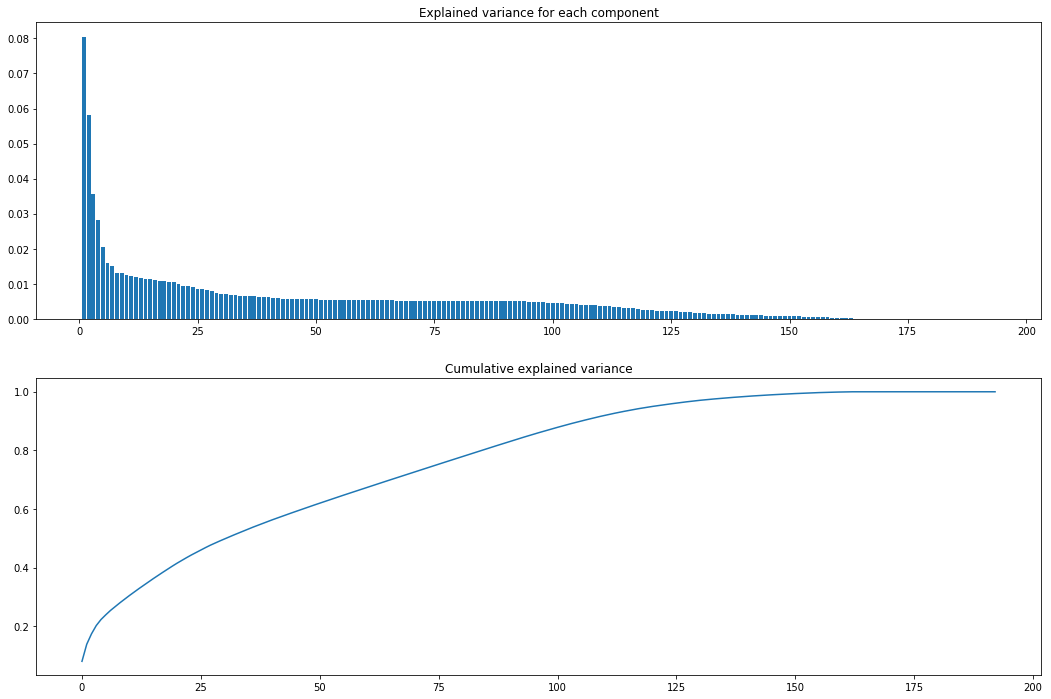

In [10]:
fig, axarr = plt.subplots(2, 1, figsize=(18, 12))
axarr[0].bar(list(range(1, len(pct_explained_variance)+1)), pct_explained_variance)
axarr[0].set_title("Explained variance for each component")

axarr[1].plot(cumul_pct_exp_variance)
axarr[1].set_title("Cumulative explained variance")

In [11]:
cumul_pct_exp_variance[100]

0.87872394370525087

In [12]:
cumul_pct_exp_variance[10]

0.30523333828993265

In [13]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(n_components=10)
azdias_pca = pca.fit_transform(azdias_scaled)

### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

After performing PCA, I'll choose to keep 10 components. The "elbow" in the scree plot is rather low, around 10 by visual examination and it would only capture around 30% of the variance in the data. Ideally, I'd like to capture more variance in the data, but choosing too many components would make k-means clustering more computationally intensive and also possibly make it harder to find distinct clusters due to the curse of dimensionality. The point of PCA is to perform dimension reduction so that we have a manageable feature set to use, so I'll choose 10 and see what the results look like. If they aren't satisfactory, I can come back and increase the number of components.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [14]:
def get_top_three_features(i):
    top_three = sorted([x for x in zip(pca.components_[i-1], azdias_df.columns)], key=lambda x: -abs(x[0]))[0:3]
    print("Top three weighted features for principal component {}".format(i))
    for num, pair in enumerate(top_three):
        print("{}: {:30s}\tWeight: {}".format(num+1, pair[1], pair[0]))
    return top_three

In [15]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
get_top_three_features(1)

Top three weighted features for principal component 1
1: MOBI_REGIO                    	Weight: -0.20504240938950125
2: LP_STATUS_GROB_1.0            	Weight: 0.19494522252971858
3: KBA05_ANTG1                   	Weight: -0.19160364007576472


[(-0.20504240938950125, 'MOBI_REGIO'),
 (0.19494522252971858, 'LP_STATUS_GROB_1.0'),
 (-0.19160364007576472, 'KBA05_ANTG1')]

In [16]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
get_top_three_features(2)

Top three weighted features for principal component 2
1: PRAEGENDE_JUGENDJAHRE_DECADE  	Weight: -0.23570450926616043
2: ALTERSKATEGORIE_GROB          	Weight: 0.23190605822712337
3: FINANZ_SPARER                 	Weight: -0.22574917289546773


[(-0.23570450926616043, 'PRAEGENDE_JUGENDJAHRE_DECADE'),
 (0.23190605822712337, 'ALTERSKATEGORIE_GROB'),
 (-0.22574917289546773, 'FINANZ_SPARER')]

In [17]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
get_top_three_features(3)

Top three weighted features for principal component 3
1: ANREDE_KZ                     	Weight: -0.3418094157654844
2: SEMIO_VERT                    	Weight: 0.3183121378991848
3: SEMIO_KAEM                    	Weight: -0.31096423832514913


[(-0.3418094157654844, 'ANREDE_KZ'),
 (0.31831213789918478, 'SEMIO_VERT'),
 (-0.31096423832514913, 'SEMIO_KAEM')]

### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

* `MOBI_REGIO` is a variable representing movement in the region, with low numbers representing higher movement, `LP_STATUS_GROB_1.0` is a dummy indicator for whether or not a customer is a low-income earner, `KBA05_ANTG1` represents number of 1-2 family homes in the microcell. Taken together, higher values for PC1 indicate an individual that is more likely to be a low-income earner that lives in a region that is characterized by higher movement, and has a low number of 1-2 family homes in the microcell.
* `PRAEGENDE_JUGENDJAHRE_DECADE` is a derived variable that indicates the decade of the dominating movement of person's youth with 0 representing the 40s and 15 representing the 90s. `ALTERSKATEGORIE_GROB` is estimated age based on given name analysis. `FINANZ_SPARER` indicates how much of a money-saver the individual is with, lower values being more conservative. Taken together, higher values for PC2 indicate an individual that is likely to be older, with a higher level of financial conservativeness.
* `ANREDE_KZ` is gender, with 1 male and 2 female. `SEMIO_VERT` and `SEMIO_KAEM` are personality typologies, with VERT representing dreamful and KAEM representing combative. Lower numbers indicate greater affinity. Taken together, higher values for PC3 indicate an individual that is more likely be be male, more combative, and less dreamful.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [18]:
MIN_CLUST = 2
MAX_CLUST = 20

In [19]:
all_avg_dists = []
# all_cluster_scores = []

# Over a number of different cluster counts...
for k in range(MIN_CLUST, MAX_CLUST):
    print(k)

    # run k-means clustering on the data and...
    kmeans = KMeans(n_clusters=k, random_state=1234, n_jobs=-1)
    kmeans.fit(azdias_pca)
    
    # compute the average within-cluster distances.
    total_dist = 0
    for i in range(azdias_pca.shape[0]):
        label = kmeans.labels_[i]
        dist = np.linalg.norm(azdias_pca[i] - kmeans.cluster_centers_[label])
        total_dist += dist
    avg_dist = total_dist / azdias_pca.shape[0]
    
    # Save avg dist
    all_avg_dists.append(avg_dist)
    # all_cluster_scores.append(kmeans.score(azdias_pca))

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


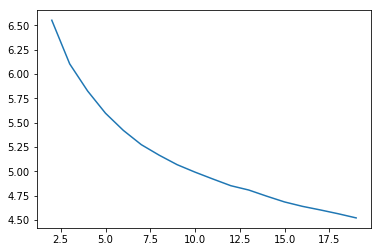

In [20]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.plot(range(MIN_CLUST, MAX_CLUST), all_avg_dists)

In [21]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
SELECTED_K = 10

kmeans = KMeans(n_clusters=SELECTED_K, random_state=1234, n_jobs=-1)
kmeans.fit(azdias_pca)
azdias_label_preds = kmeans.labels_

### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

* From the plot of average distances w.r.t. number of clusters, there is no clear elbow, but the rate at which the average distance is decreasing appears to taper off starting at around 10 clusters. I would also not want to choose too many cluster, because then the analysis of the clusters themselves may become cumbersome; we'd like a reasonable number of clusters that make sense; therefore I will choose to segment the population into 10 clusters.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [22]:
# Load in the CLEAN customer demographics data. 
# (Data was cleaned in an earlier cell in this notebook when clean_df was defined)
customers = pd.read_csv("cust_FINAL_CLEAN.csv")

In [23]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers = imp.transform(customers)
customers = ss.transform(customers)
customers = pca.transform(customers)
customers_label_preds = kmeans.predict(customers)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [33]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
unique, azdias_counts = np.unique(azdias_label_preds, return_counts=True)
unique, customer_counts = np.unique(customers_label_preds, return_counts=True)

In [41]:
# Get "above threshold" datasets from step 1.1.3
azdias_dropped_outliers = pd.read_csv("azdias_dropped_outliers.csv")
azdias_above_threshold = get_outlier_rows(azdias_dropped_outliers)

customer_df = pd.read_csv("Udacity_CUSTOMERS_Subset.csv", delimiter=";")
customer_cleaned = replace_missing_value_codes(customer_df)
customer_dropped_outliers = customer_cleaned.drop(outlier_columns, axis=1)
customer_above_threshold = get_outlier_rows(customer_dropped_outliers)

Replacing missing value codes with np.nan for column 0/84...
Replacing missing value codes with np.nan for column 5/84...
Replacing missing value codes with np.nan for column 10/84...
Replacing missing value codes with np.nan for column 15/84...
Replacing missing value codes with np.nan for column 20/84...
Replacing missing value codes with np.nan for column 25/84...
Replacing missing value codes with np.nan for column 30/84...
Replacing missing value codes with np.nan for column 35/84...
Replacing missing value codes with np.nan for column 40/84...
Replacing missing value codes with np.nan for column 45/84...
Replacing missing value codes with np.nan for column 50/84...
Replacing missing value codes with np.nan for column 55/84...
Replacing missing value codes with np.nan for column 60/84...
Replacing missing value codes with np.nan for column 65/84...
Replacing missing value codes with np.nan for column 70/84...
Replacing missing value codes with np.nan for column 75/84...
Replacing 

In [42]:
azdias_counts = np.append(azdias_counts, azdias_above_threshold.shape[0])
customer_counts = np.append(customer_counts, customer_above_threshold.shape[0])

In [43]:
azdias_props = azdias_counts / sum(azdias_counts) * 100
customer_props = customer_counts / sum(customer_counts) * 100

Text(0.5,0,'Cluster label')

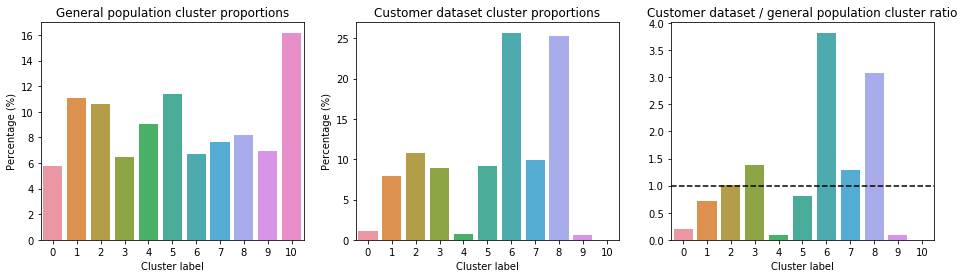

In [44]:
# Plot proportion of data and ratio
fig, axarr = plt.subplots(1, 3, figsize=(16, 4))
sns.barplot(np.arange(0, 11), azdias_props, ax=axarr[0])
sns.barplot(np.arange(0, 11), customer_props, ax=axarr[1])
sns.barplot(np.arange(0, 11), customer_props / azdias_props, ax=axarr[2])
axarr[0].set_title("General population cluster proportions")
axarr[0].set_ylabel("Percentage (%)")
axarr[0].set_xlabel("Cluster label")
axarr[1].set_title("Customer dataset cluster proportions")
axarr[1].set_ylabel("Percentage (%)")
axarr[1].set_xlabel("Cluster label")
axarr[2].set_title("Customer dataset / general population cluster ratio")
axarr[2].axhline(1, color="black", linestyle="--")
axarr[2].set_xlabel("Cluster label")

In [47]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# Clusters 6 and 8 are overrepresented in the customer population
print(kmeans.cluster_centers_[6])
print(kmeans.cluster_centers_[8])

[-4.33335188  0.07767452  3.34006149  2.60803951 -0.61715923 -0.70101818
 -0.32120895 -0.40978563  0.28572786  0.03387943]
[-0.44369567 -3.63993504 -2.99150733  0.05171171 -0.90180267  0.84364775
 -0.47045778  0.1469595  -0.05055352  0.01686493]


In [48]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

# Clusters 4, 0, and 9 and 10 underrepresented in the customer population
print(kmeans.cluster_centers_[0])
print(kmeans.cluster_centers_[4])
print(kmeans.cluster_centers_[9])

[-1.06037716 -4.84552978  2.46474047 -1.03303515 -0.63711409  0.7652301
 -0.54776525  0.04649818  0.12767417 -0.23677456]
[ 5.22225662 -1.96929486 -2.36694618  0.98194672  0.07481966 -0.42516443
  0.02641689 -0.35993244  0.35856639  0.34509272]
[ 4.96641412 -2.64196438  2.82014989 -0.53939234  0.09356748 -0.28935068
 -0.04295781 -0.40619078  0.2577095   0.08537016]


### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

* Clusters that are overrepresented in the customer data compared to the general population are 8 and 6.
    * Cluster 8 has a small negative weight on the first component, and large negative weights on the second and third components. Using the interpretations of PCs in 2.3, this represents a cluster that is on average, a **middle-class, younger and less financially conservative, optimistic female**.
    * Cluster 6 has a large negative weight on the first component, a small positive weight on the second component, and a large positive weight on the third component. Using the interpretations of PCs in 2.3, this represents a cluster that is on average, a **high income, middle-aged, realistic/combative male**.
* Clusters that are underrepresented in the customer data compared to the general population are 0, 4, 9 and 10.
    * Cluster 9 has a large positive weight on the first component, a large negative weight on the second component, and a large positive weight on the third component. Using the interpretations of PCs in 2.3, this represents a cluster that is on average, a **low income, younger and less financially conservative, realistic/combative male**.
    * Cluster 0 has a moderate negative weight on the first component, a large negative weight on the second component, and a moderate positive weight on the third component. Using the interpretations of PCs in 2.3, this represents a cluster that is on average, a **moderately high income, younger and less financially conservative, moderately realistic male**.
    * Cluster 4 has a large positive weight on the first component, and moderate negative weights on the second and third components. Using the interpretations of PCs in 2.3, this represents a cluster that is on average, a **low income, slightly younger and somewhat financially conservative, moderately optimistic female**.
    * Cluster 10 is not associated with a cluster center; it consists of the individuals that had a high number of missing features. In fact, there are none of these individuals in the customer dataset.
    
Looking at all this data together, it seems that overall the customer segments that are popular with the company are **young, middle-class females** and **high-income, middle-aged conservative males**.

In contrast, the customer segments that are not popular with the company are **low-income individuals** and **young, moderately conservative high-income males**.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.